<h3 id="top">Clustering for mb customers</h3>

[1. Initial EDA](#eda)   
[2. Preprocessing pipeline](#proprocessing)    
[3. Leiden Clustering for the customers](#leiden)    
[4. K-Means Clustering for the customers](#kmeans)

> **Please read from top-down if this is the first time reading this documentation.**

In [1]:
%load_ext autoreload

import os
import sys
import pandas as pd
import scanpy as sc

from pathlib import Path
pypath = str(Path(os.getcwd()).parent / 'app')
sys.path.append(pypath)
import clustering
import sctoolkit.sctoolkit.utils as sctk_utils

from IPython.display import display
pd.options.mode.chained_assignment = None # turn off warning


# turn off all the warning message
import warnings
warnings.filterwarnings("ignore")


<h3 id="eda" style='background:purple; border:0; color:white'><center>1. Initial EDA</h3>

[Back to Top](#top)

In [3]:
df_data = pd.read_excel('../data/Assessment.xlsx', 
                        sheet_name='Data', index_col=0)
df_data.shape
# df_data.index.value_counts()
# df_data[df_data.index == 59688]

(66083, 29)

In [4]:
# retain the row with highest C_AGE value and remove the rest of duplicated values by index
df_data.reset_index(inplace=True)
df_data = df_data.loc[df_data.groupby('C_ID')['C_AGE'].idxmax()]
df_data.set_index('C_ID', inplace=True)

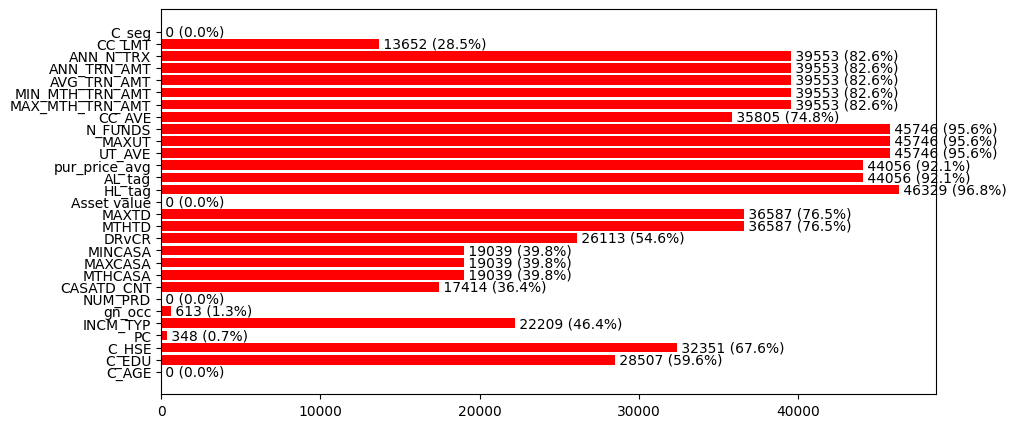

In [5]:
# visualization for missing values in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5))

for i, col in enumerate(df_data.columns):
    plt.barh(col, df_data[col].isnull().sum(), color='red')
    # add count and percentage of missing values
    plt.text(df_data[col].isnull().sum(), i, 
             f" {df_data[col].isnull().sum()} ({df_data[col].isnull().mean():.1%})",
             ha='left', va='center')



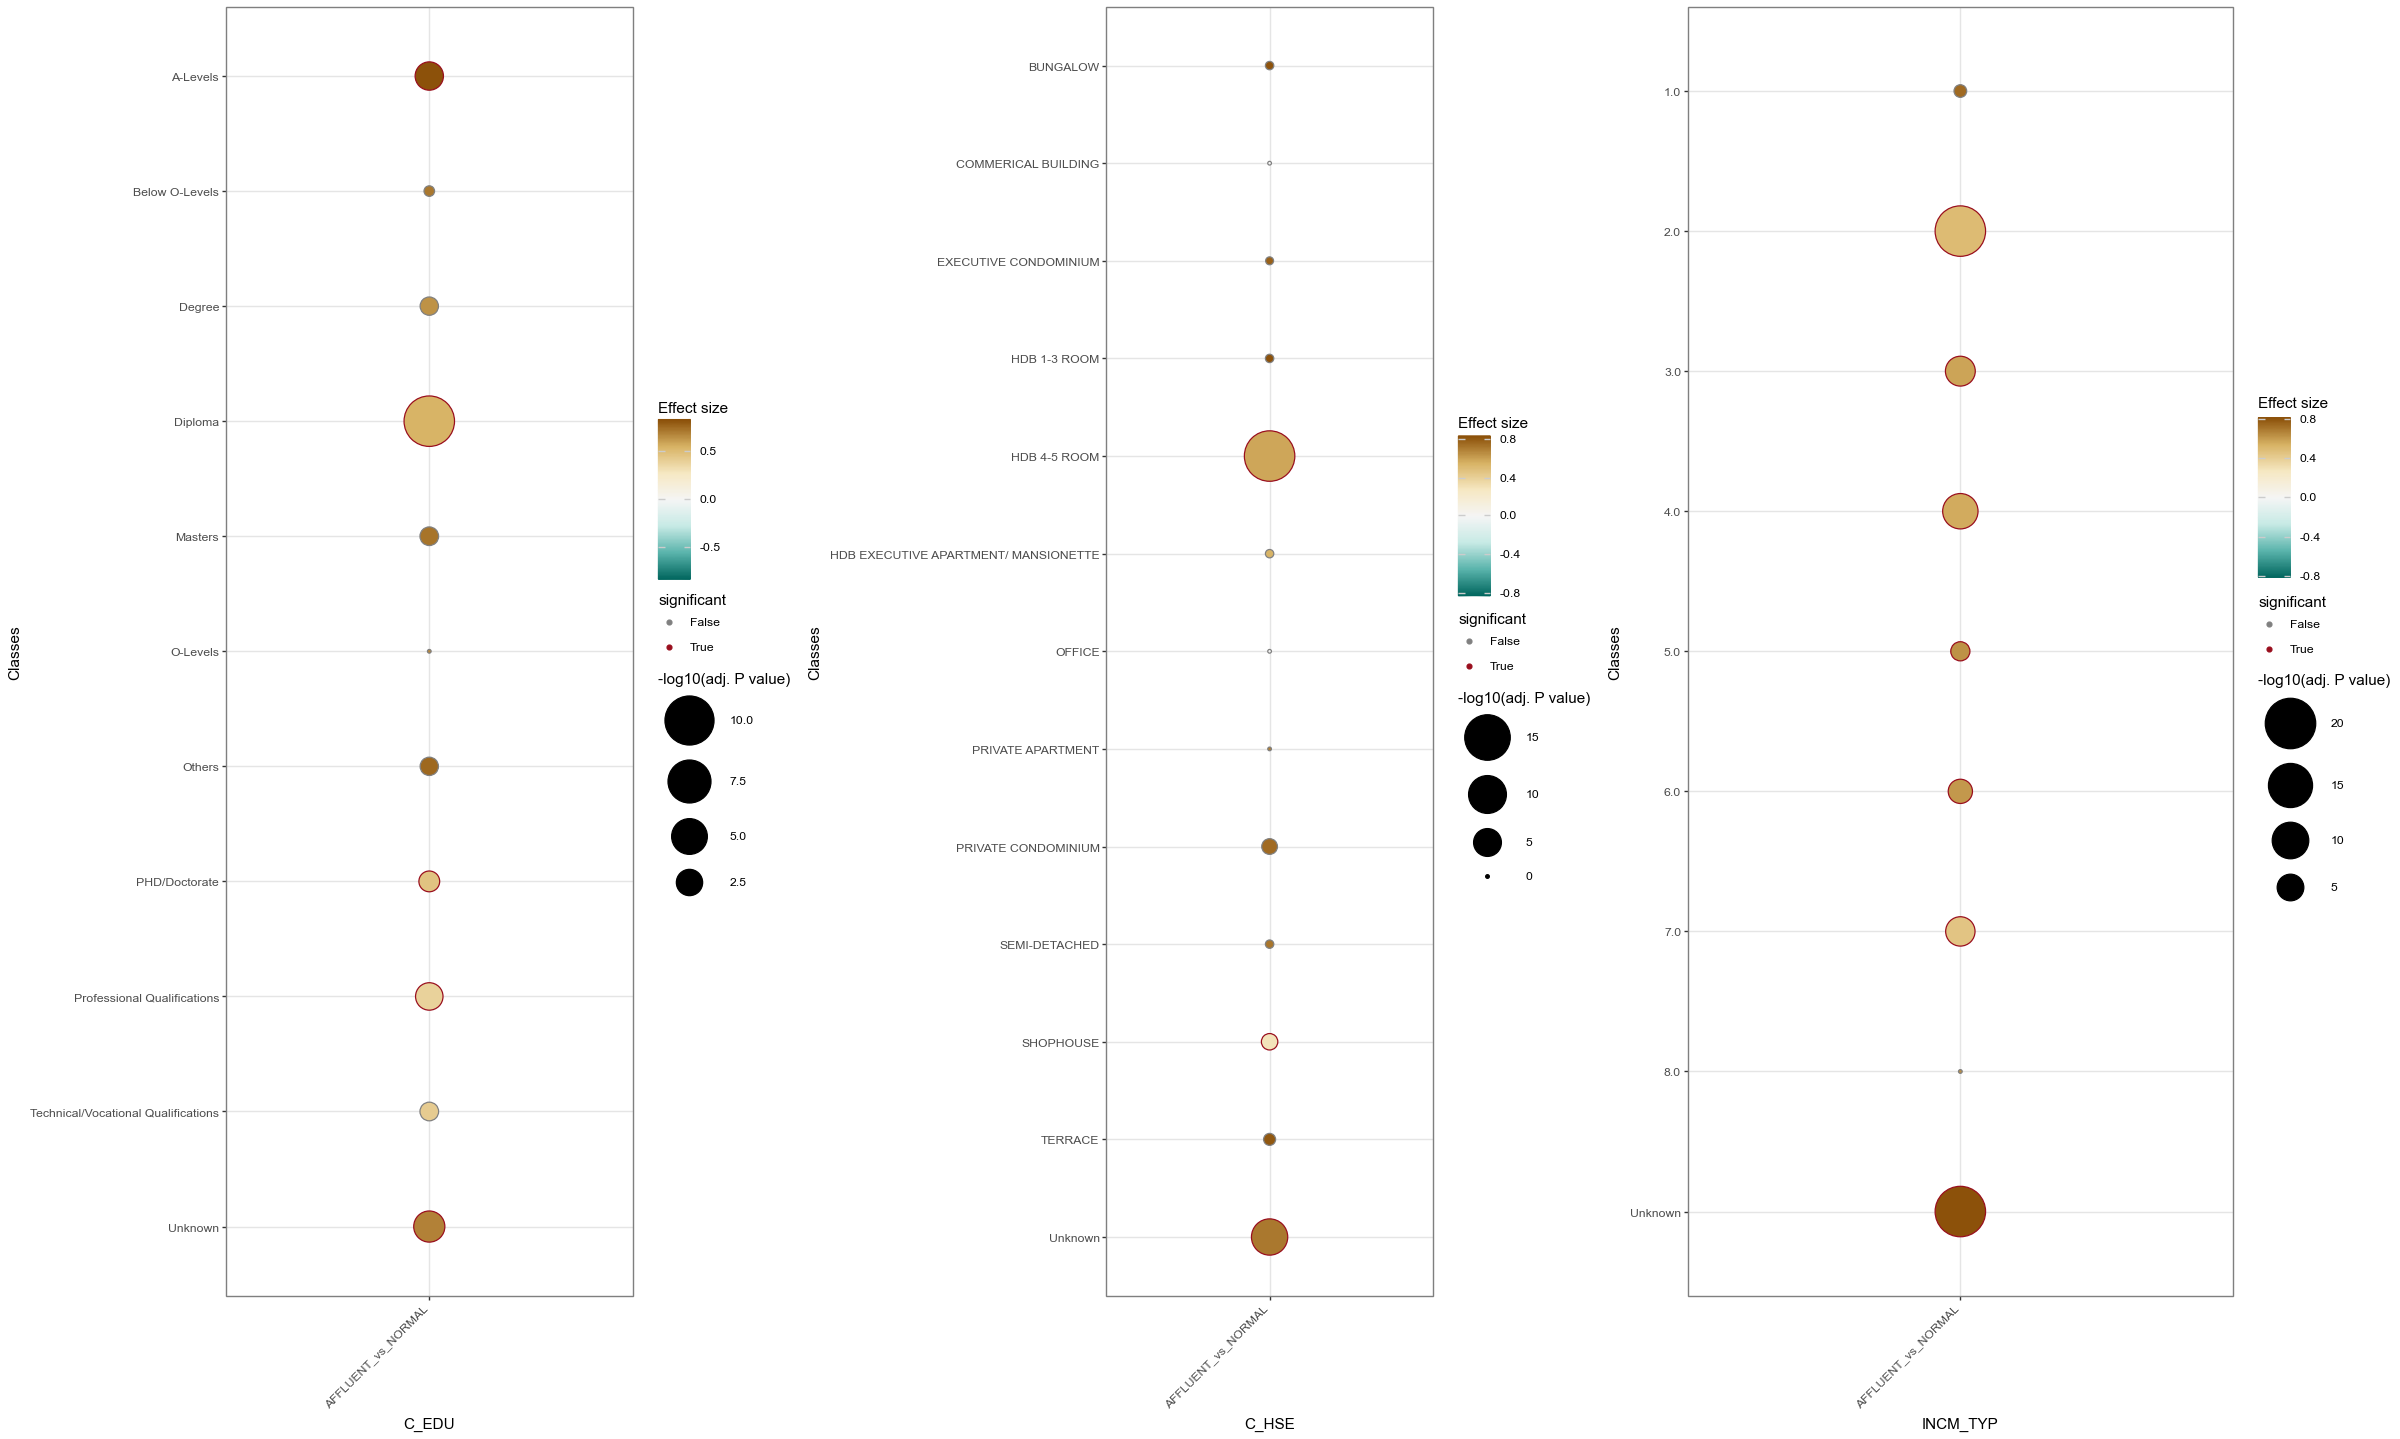

In [6]:
%autoreload
from clustering.analysis import comparison_plot_categorical

df_results_1, fig1 = comparison_plot_categorical(
        df_input=df_data, 
        cat_features = ['C_EDU', 'C_HSE', 'INCM_TYP'],
        target_label='C_seg',
        save_path='figures/dotplot_compare_cat_1.png'
        )

# display(df_results_1)
fig1

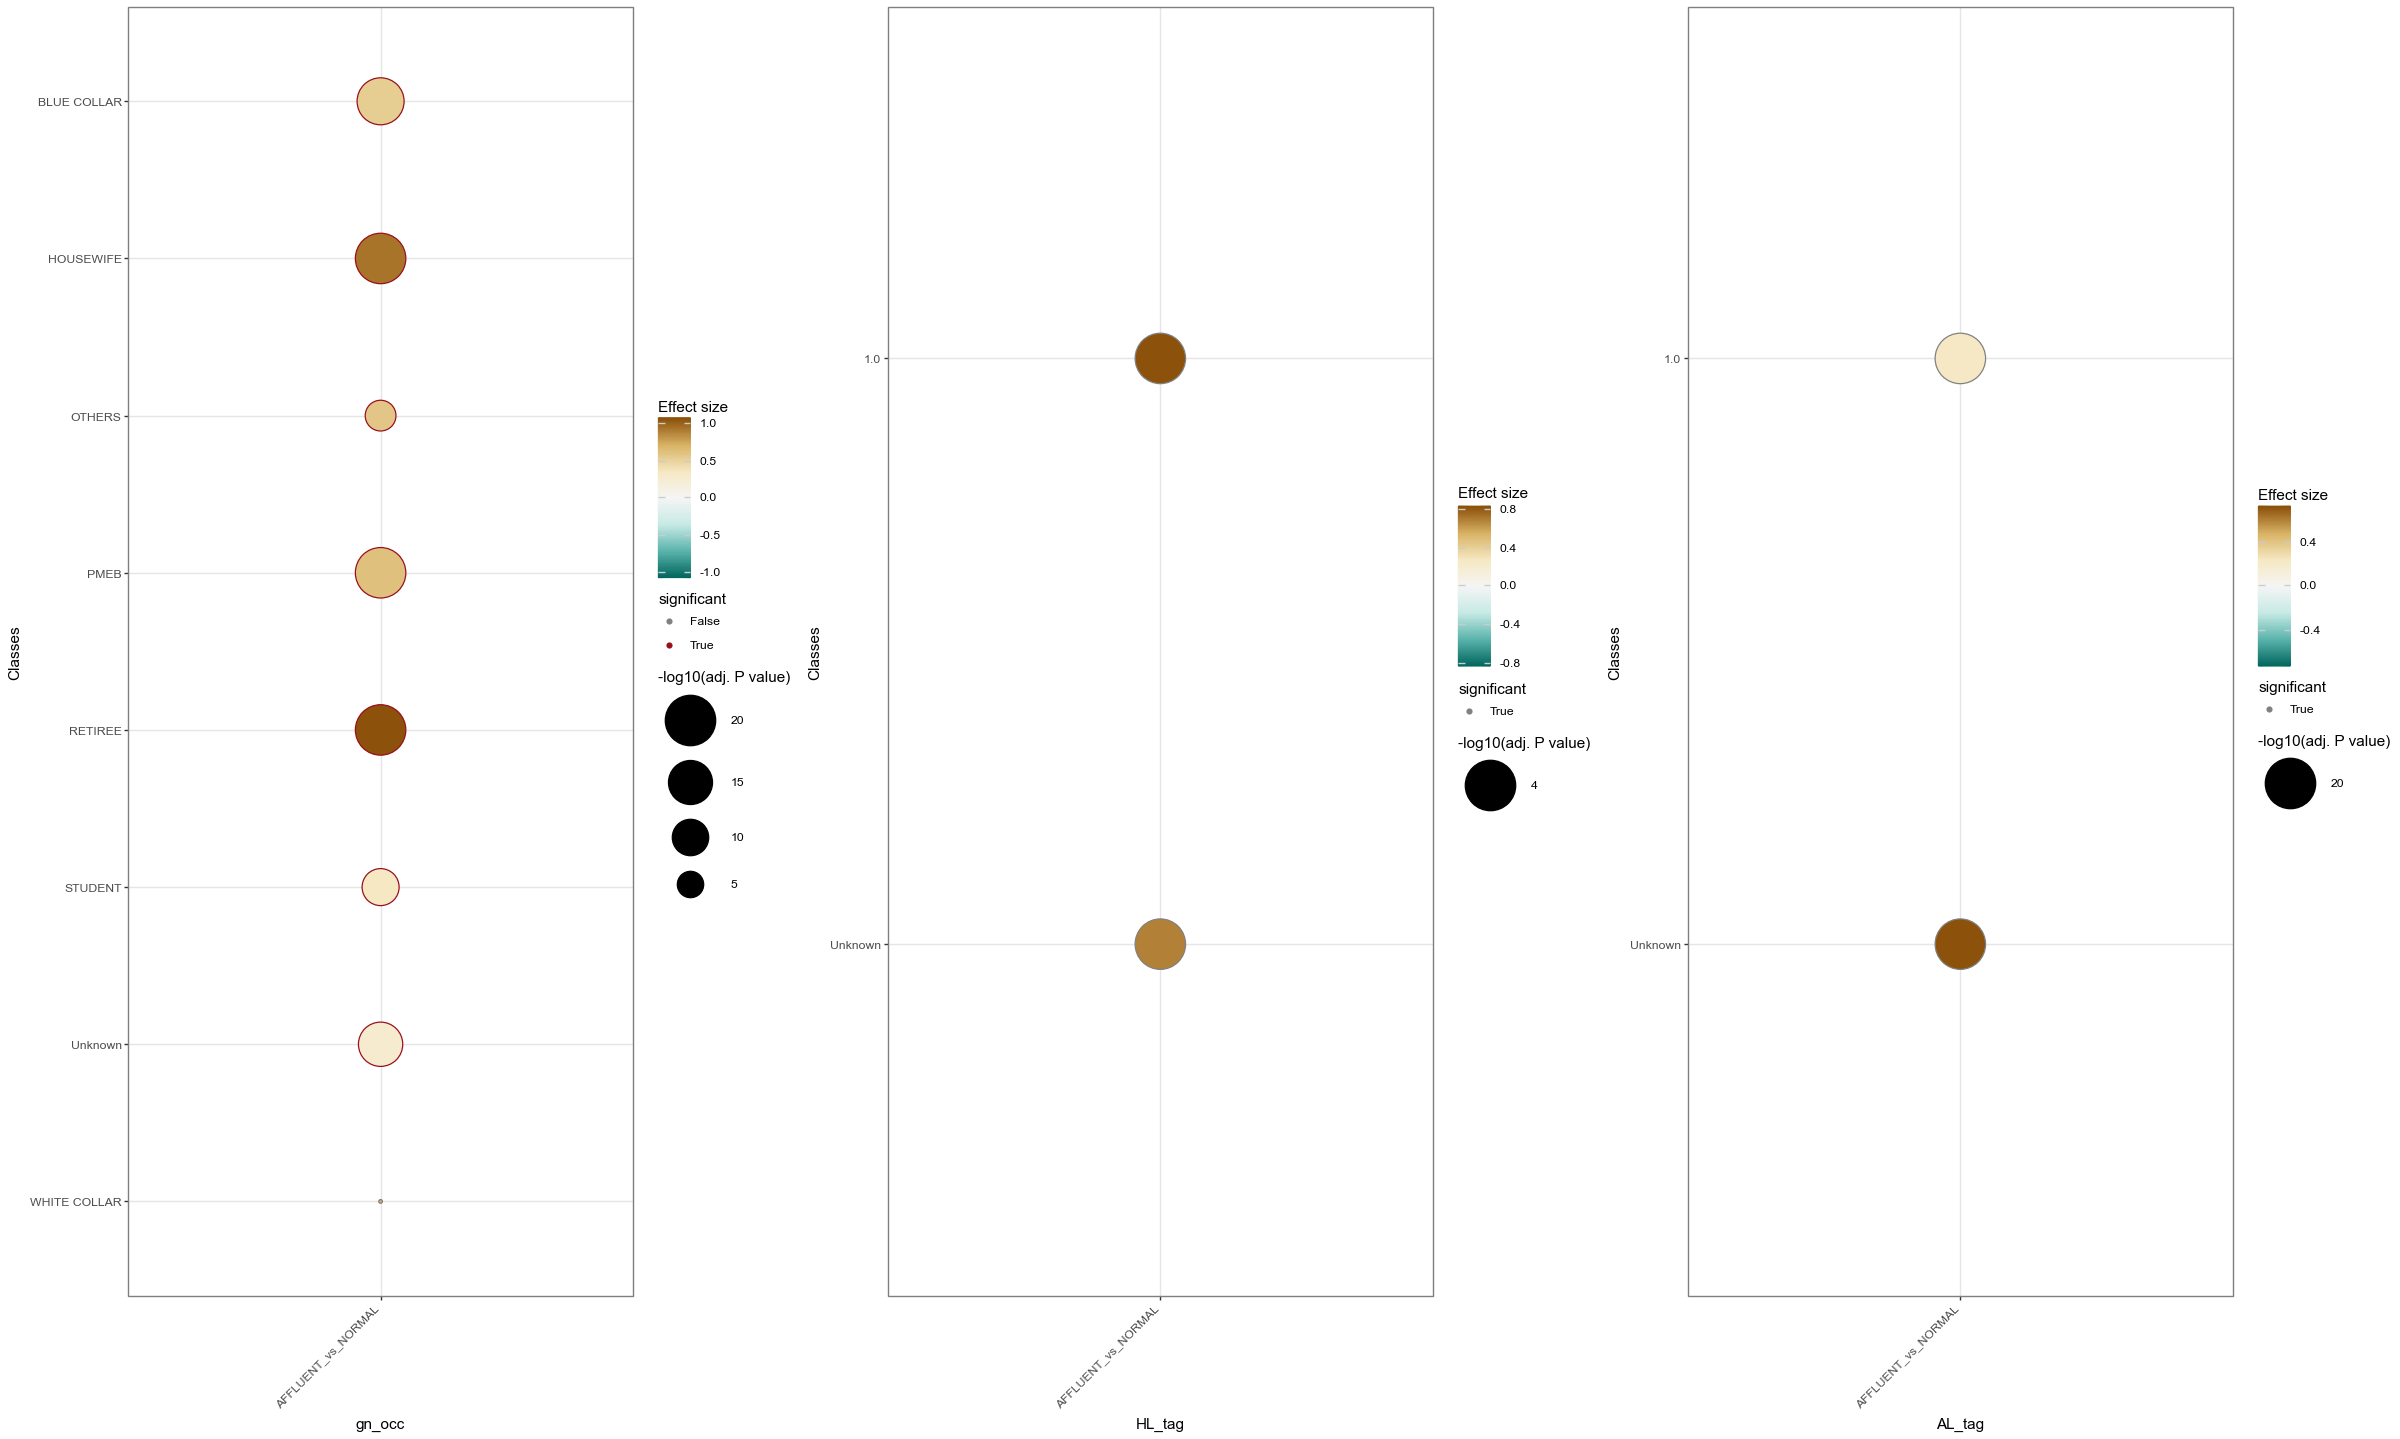

In [7]:
%autoreload
from clustering.analysis import comparison_plot_categorical

df_results_2, fig2 = comparison_plot_categorical(
        df_input=df_data, 
        cat_features = ['gn_occ', 'HL_tag', 'AL_tag'],
        target_label='C_seg',
        save_path='figures/dotplot_compare_cat_2.png'
        )

# display(df_results_2)
fig2

In [8]:
# get list of columns with object type
# ls_cat = df_data.select_dtypes(include=['object']).columns
ls_cat = ['C_EDU', 'C_HSE', 'INCM_TYP', 'gn_occ', 'HL_tag', 'AL_tag']

# get list of columns with numeric type
# ls_num = df_data.select_dtypes(include=['float64', 'int64']).columns
ls_num = df_data.columns.difference(ls_cat)
ls_num = ls_num.drop('PC') # Postcode is ignore -- assuming the place a person lives does not affect the segmentation
ls_num = ls_num.drop('C_seg') # C_seg is a target label

# target label
target_label = 'C_seg'

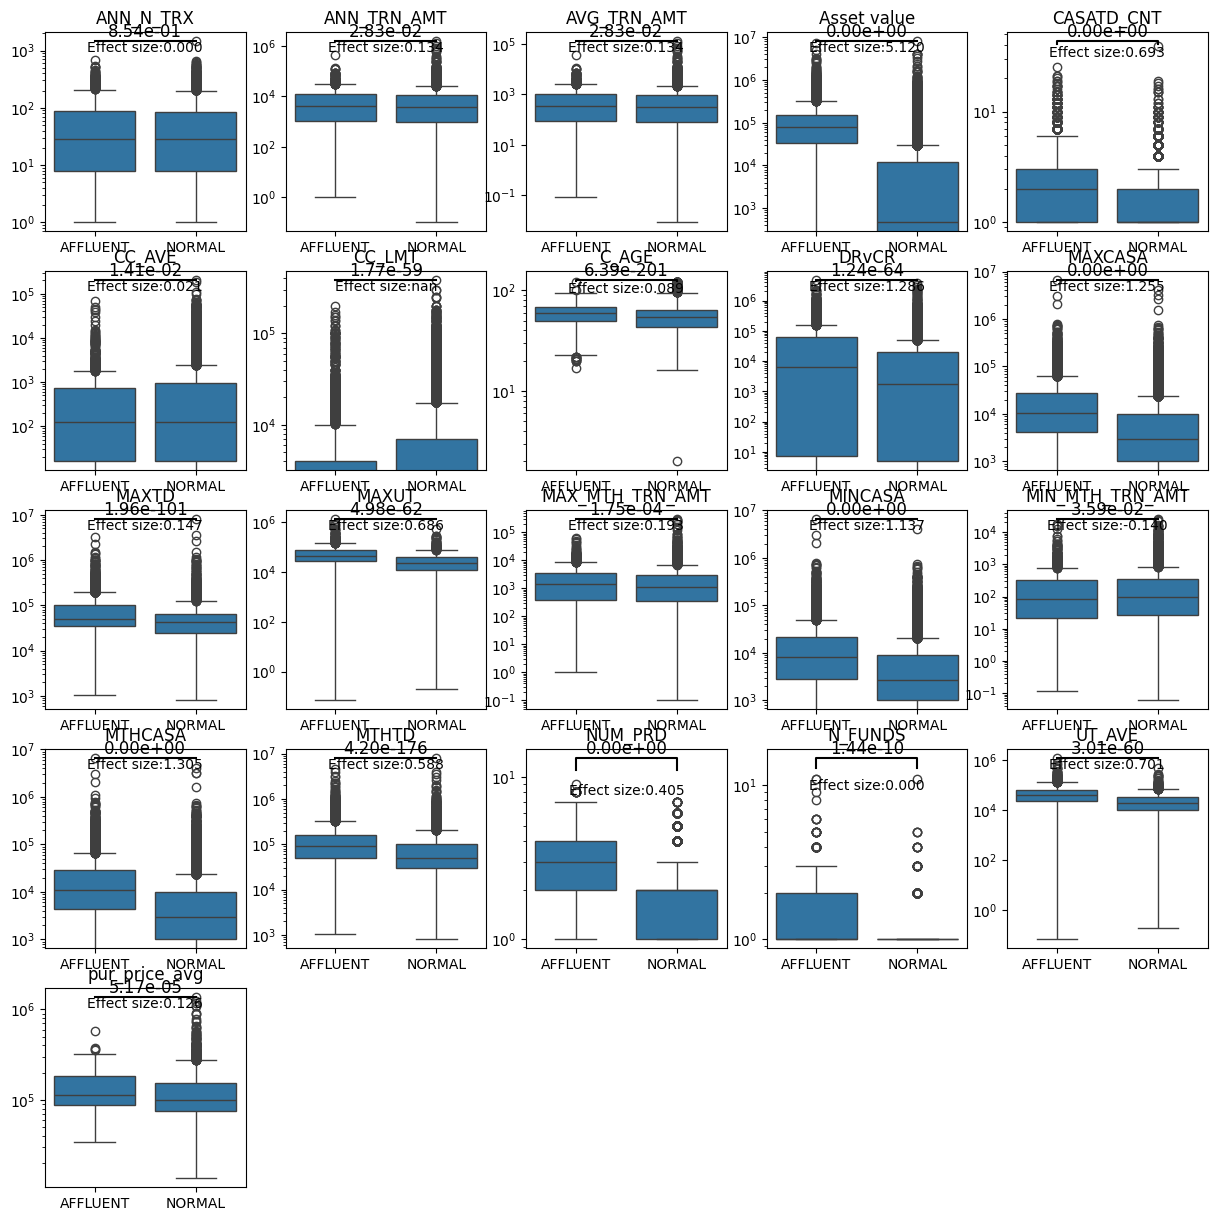

In [9]:
%autoreload
from clustering.analysis import comparison_plot_numerical

# comparing the distribution of numeric features by the target label, note that the missing values were dropped per chart analysis
comparison_plot_numerical(
    df_input=df_data, 
    numeric_features=ls_num, 
    target_label='C_seg', 
    statsmethod='mannwhitneyu',
    figsize=(15, 15)  
)

In [10]:
ls_non_sig_num = ['ANN_N_TRX','ANN_TRN_AMT','AVG_TRN_AMT', 'MIN_MTH_TRN_AMT', 'CC_AVE']
for col in ls_non_sig_num:
    ls_num = ls_num.drop(col)

ls_num = list(ls_num)

In [11]:
# impute missing values of categorical columns with 'missing'
df_data[ls_cat] = df_data[ls_cat].fillna('missing')

# impute missing values of numeric columns with zero
df_data[ls_num] = df_data[ls_num].fillna(0)


<h3 id="preprocessing" style='background:purple; border:0; color:white'><center>2. Preprocessing pipeline</h3>

[Back to Top](#top)

In [12]:
%autoreload
pipe_ml = clustering.pp.create_pipe_ml(
    ls_num_features=ls_num,
    ls_cat_features=ls_cat
    )

df_features = df_data[ls_num + ls_cat]

# set dtypes of df_data to object or float according to ls_num and ls_cat
df_features[ls_cat] = df_features[ls_cat].astype('object')
df_features[ls_num] = df_features[ls_num].astype('float')

X_train_preprocessed_ml = pipe_ml.fit_transform(df_features)

# obtain onehot features list
ls_onehot_features = list(pipe_ml['preprocessor'].transformers_[1][1]['onehot']\
                          .get_feature_names_out(ls_cat))

X_train_preprocessed_ml = pd.DataFrame(X_train_preprocessed_ml, 
                                   columns=ls_num + ls_onehot_features,
                                     index=df_features.index)
len(X_train_preprocessed_ml.columns)
X_train_preprocessed_ml


,Asset value,CASATD_CNT,CC_LMT,C_AGE,DRvCR,MAXCASA,MAXTD,MAXUT,MAX_MTH_TRN_AMT,MINCASA,...,gn_occ_BLUE COLLAR,gn_occ_HOUSEWIFE,gn_occ_OTHERS,gn_occ_PMEB,gn_occ_RETIREE,gn_occ_STUDENT,gn_occ_WHITE COLLAR,gn_occ_missing,HL_tag_missing,AL_tag_missing
C_ID,,,,,,,,,,,,,,,,,,,,,
0,35373.02,1.0,0.0,61.0,3.346907,35373.02,0.00,0.0,0.00,35373.02,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.00,0.0,0.0,41.0,0.000000,0.00,0.00,0.0,0.00,0.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,161459.06,3.0,0.0,70.0,0.000000,8502.87,101006.19,0.0,0.00,8502.87,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
9,100688.16,3.0,0.0,44.0,0.000000,34517.56,0.00,0.0,0.00,32085.09,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
11,47782.61,1.0,25000.0,70.0,1879.050000,47782.61,0.00,0.0,1250.55,47782.61,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99977,584.77,1.0,0.0,30.0,0.000000,584.77,0.00,0.0,0.00,584.77,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
99980,2202.26,1.0,0.0,45.0,5020.000000,2202.26,0.00,0.0,0.00,2202.26,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
99989,0.00,0.0,11500.0,47.0,0.000000,0.00,0.00,0.0,4521.98,0.00,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [13]:
onehot_cols_to_drop = ['C_EDU_Below O-Levels', 'C_EDU_Degree', 'C_EDU_Masters', 
                'C_EDU_O-Levels', 'C_EDU_Others', 'C_EDU_Technical/Vocational Qualifications', 
                'C_HSE_BUNGALOW', 'C_HSE_COMMERICAL BUILDING', 'C_HSE_EXECUTIVE CONDOMINIUM', 
                'C_HSE_HDB 1-3 ROOM', 'C_HSE_HDB EXECUTIVE APARTMENT/ MANSIONETTE',
                'C_HSE_OFFICE', 'C_HSE_PRIVATE APARTMENT', 'C_HSE_PRIVATE CONDOMINIUM',
                'C_HSE_SEMI-DETACHED', 'C_HSE_TERRACE', 'INCM_TYP_1.0', 'INCM_TYP_8.0',
                'gn_occ_WHITE COLLAR'
       ]
for col in onehot_cols_to_drop:
    X_train_preprocessed_ml = X_train_preprocessed_ml.drop(col, axis=1)

X_train_preprocessed_ml.columns


Index(['Asset value', 'CASATD_CNT', 'CC_LMT', 'C_AGE', 'DRvCR', 'MAXCASA',
       'MAXTD', 'MAXUT', 'MAX_MTH_TRN_AMT', 'MINCASA', 'MTHCASA', 'MTHTD',
       'NUM_PRD', 'N_FUNDS', 'UT_AVE', 'pur_price_avg', 'C_EDU_A-Levels',
       'C_EDU_Diploma', 'C_EDU_PHD/Doctorate',
       'C_EDU_Professional Qualifications', 'C_EDU_missing',
       'C_HSE_HDB 4-5 ROOM', 'C_HSE_SHOPHOUSE', 'C_HSE_missing',
       'INCM_TYP_2.0', 'INCM_TYP_3.0', 'INCM_TYP_4.0', 'INCM_TYP_5.0',
       'INCM_TYP_6.0', 'INCM_TYP_7.0', 'INCM_TYP_missing',
       'gn_occ_BLUE COLLAR', 'gn_occ_HOUSEWIFE', 'gn_occ_OTHERS',
       'gn_occ_PMEB', 'gn_occ_RETIREE', 'gn_occ_STUDENT', 'gn_occ_missing',
       'HL_tag_missing', 'AL_tag_missing'],
      dtype='object')

<h3 id="leiden" style='background:purple; border:0; color:white'><center>3. Leiden Clustering for the customers</h3>

[Back to Top](#top)

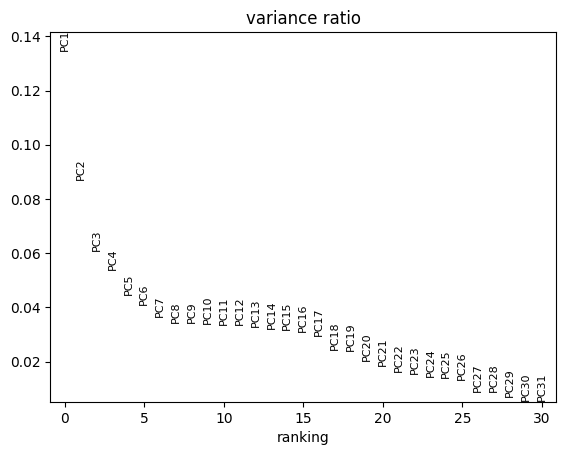

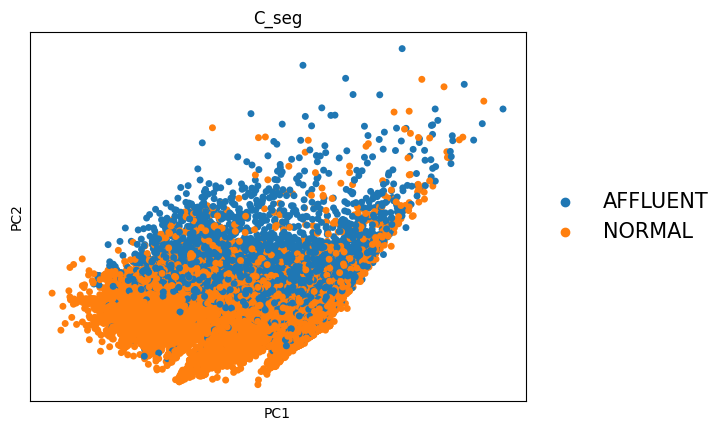

In [13]:
# Training dataset
adata = sc.AnnData(X_train_preprocessed_ml)
adata.raw = adata  # have to save the raw data for differential analyses later

# # log1p transformation 
# sc.pp.log1p(adata)

# Standardizing
sc.pp.scale(adata, max_value=10)

# Adding observation
for label in [target_label, 'C_EDU', 'C_HSE', 'INCM_TYP', 'gn_occ', 'HL_tag', 'AL_tag']:
    adata.obs[label] = df_data[df_data.index.isin(X_train_preprocessed_ml.index)][label].values 
    adata.obs[label] = df_data[label].values 

analysis_type = 'alldataset'

# Run PCA analysis
sc.tl.pca(adata, svd_solver='arpack');
sc.pl.pca_variance_ratio(adata, save=f'{analysis_type}.png');
sc.pl.pca(adata, color=[target_label], size=100, legend_fontsize=15, cmap='RdBu_r',
              save=f'_{analysis_type}_{target_label}.png');


In [14]:
# leiden clustering on significant PCs
n_PCs = 7
sc.pp.neighbors(adata, n_neighbors=250, n_pcs=n_PCs, use_rep='X_pca');
sc.tl.leiden(adata, resolution=0.5, random_state=0); # you can change the resolution setting; higher -> overfitting

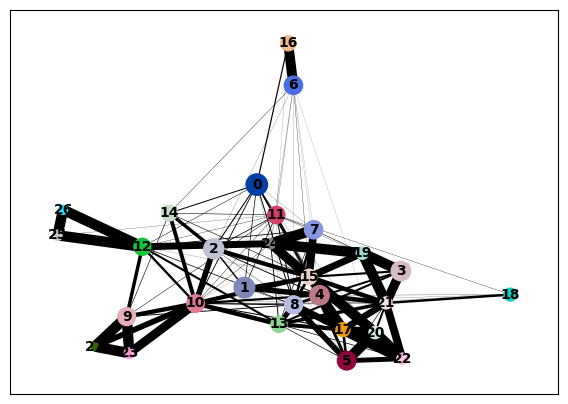

In [15]:
# Paga analysis and plotting -- the higher the weights of the edges the higher correlation/links 
# between the linked clusters
sc.tl.paga(adata);
sc.pl.paga(adata, save=f'_{analysis_type}_{target_label}.png');

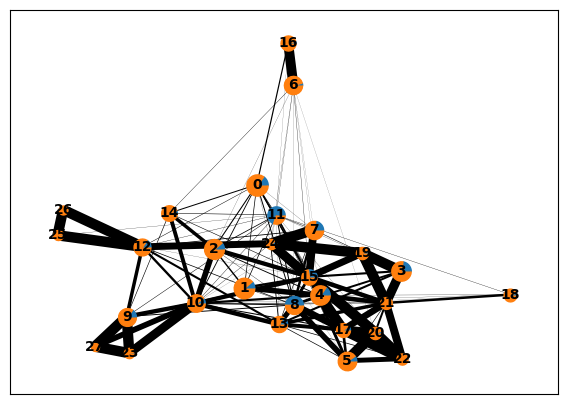

In [16]:
sc.pl.paga(adata, color=[target_label]);

In [17]:
# len(adata.obs.leiden.unique)

# UMAP - 2nd dimensional reduction on the neighbors info derived from the selected PCs
sc.tl.umap(adata, init_pos='paga');

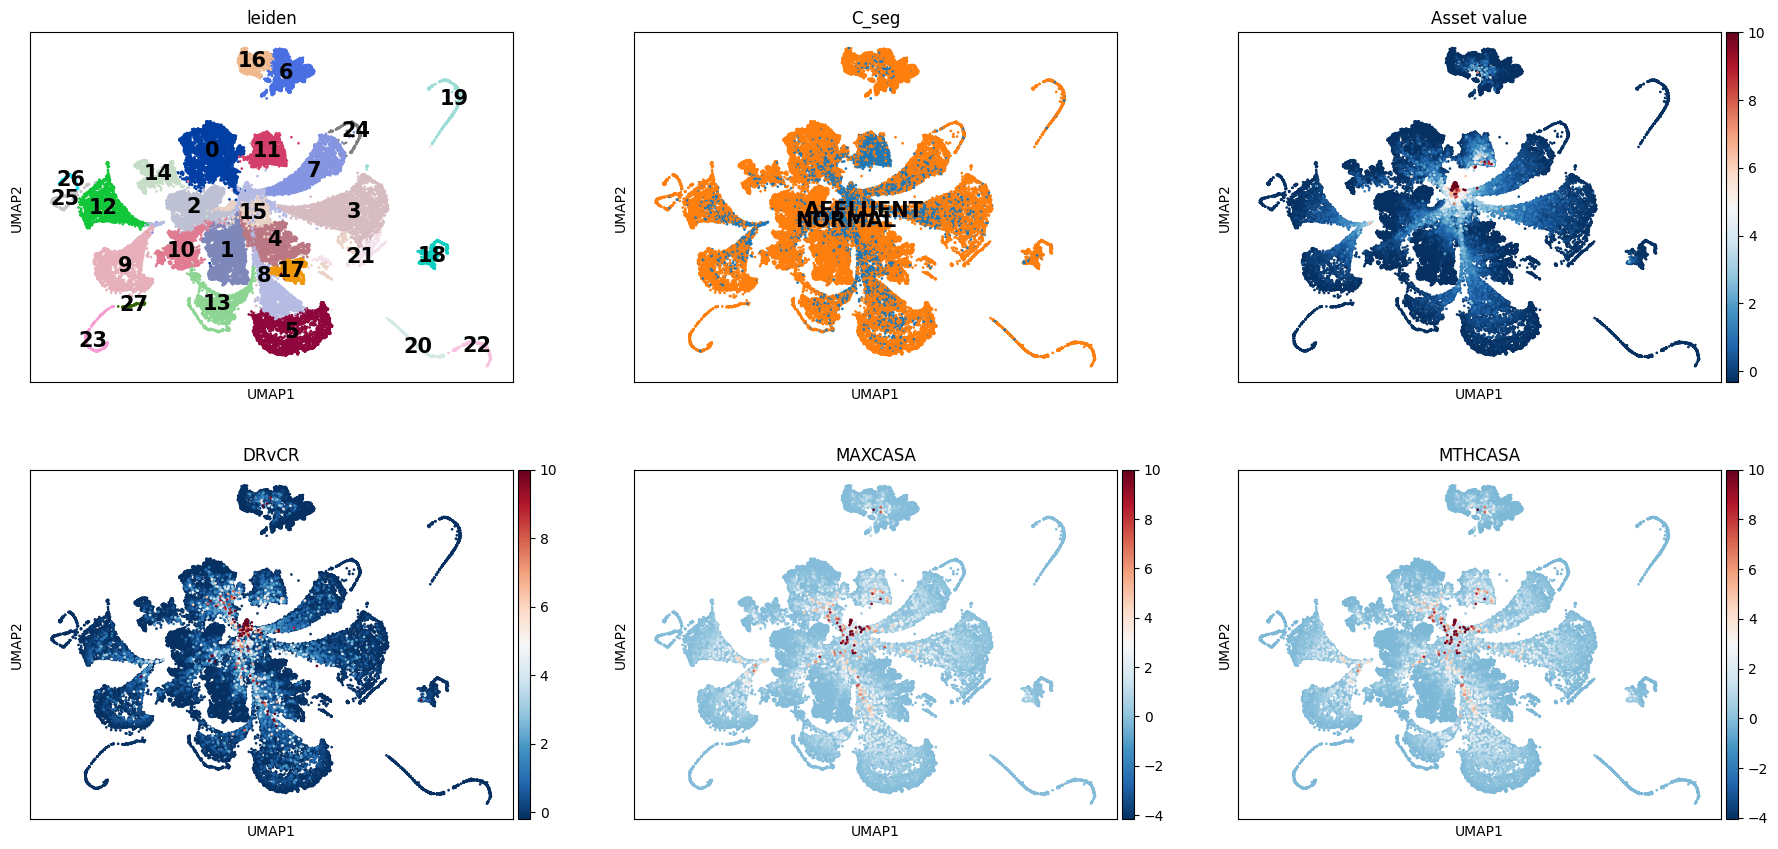

In [18]:
sc.pl.umap(adata, color=['leiden', target_label, 'Asset value', 
                         'DRvCR', 'MAXCASA', 'MTHCASA'], legend_loc='on data', 
                         size=15, legend_fontsize=15, cmap='RdBu_r', ncols=3,
                        save=f'_{analysis_type}_{target_label}_leiden.png');

In [19]:
df_obs_global = adata.obs

# group by leiden and C_seg and calculate the percentage of each C_seg value
df_obs_global.groupby(['leiden', 'C_seg']).size().unstack().apply(lambda x: x/x.sum(), axis=1).sort_values(by='AFFLUENT', ascending=False).style.background_gradient(cmap='bwr', axis=0)

C_seg,AFFLUENT,NORMAL
leiden,,
11,0.696117,0.303883
8,0.495847,0.504153
15,0.277649,0.722351
7,0.226162,0.773838
3,0.225068,0.774932
13,0.166026,0.833974
12,0.159222,0.840778
9,0.154530,0.845470
4,0.152095,0.847905


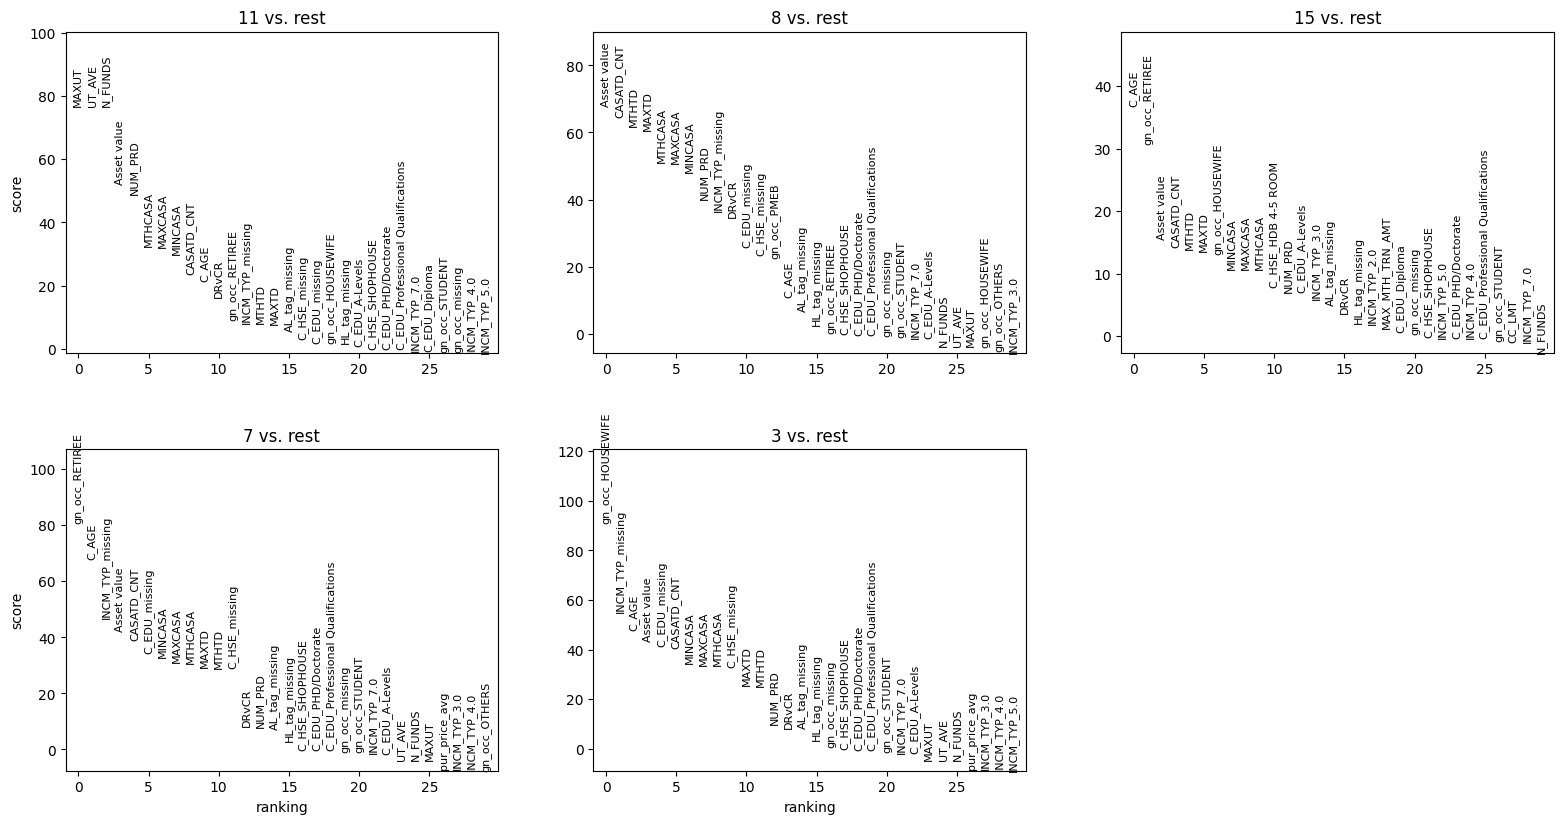

In [20]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') #groups=['TMRC'], reference='HC'
sc.pl.rank_genes_groups(adata, n_genes=30, groups=['11', '8', '15', '7', '3'], sharey=False, ncols=3, save='_top30.png')


In [21]:
adata.var_names

features_order = [
    'Asset value', 'DRvCR', 'MAXCASA', 'MTHCASA', 'MINCASA',
       'MAXTD', 'MAXUT', 'MAX_MTH_TRN_AMT',  'MTHTD',
        'CASATD_CNT', 'CC_LMT', 
       'NUM_PRD', 'N_FUNDS', 'UT_AVE', 'pur_price_avg', 'C_EDU_A-Levels',
       'C_EDU_Diploma', 'C_EDU_PHD/Doctorate',
       'C_EDU_Professional Qualifications', 'C_EDU_missing',
       'C_HSE_HDB 4-5 ROOM', 'C_HSE_SHOPHOUSE', 'C_HSE_missing',
       'INCM_TYP_2.0', 'INCM_TYP_3.0', 'INCM_TYP_4.0', 'INCM_TYP_5.0',
       'INCM_TYP_6.0', 'INCM_TYP_7.0', 'INCM_TYP_missing',
       'gn_occ_BLUE COLLAR', 'gn_occ_HOUSEWIFE', 'gn_occ_OTHERS',
       'gn_occ_PMEB', 'gn_occ_RETIREE', 'C_AGE', 'gn_occ_STUDENT', 'gn_occ_missing',
       'HL_tag_missing', 'AL_tag_missing']

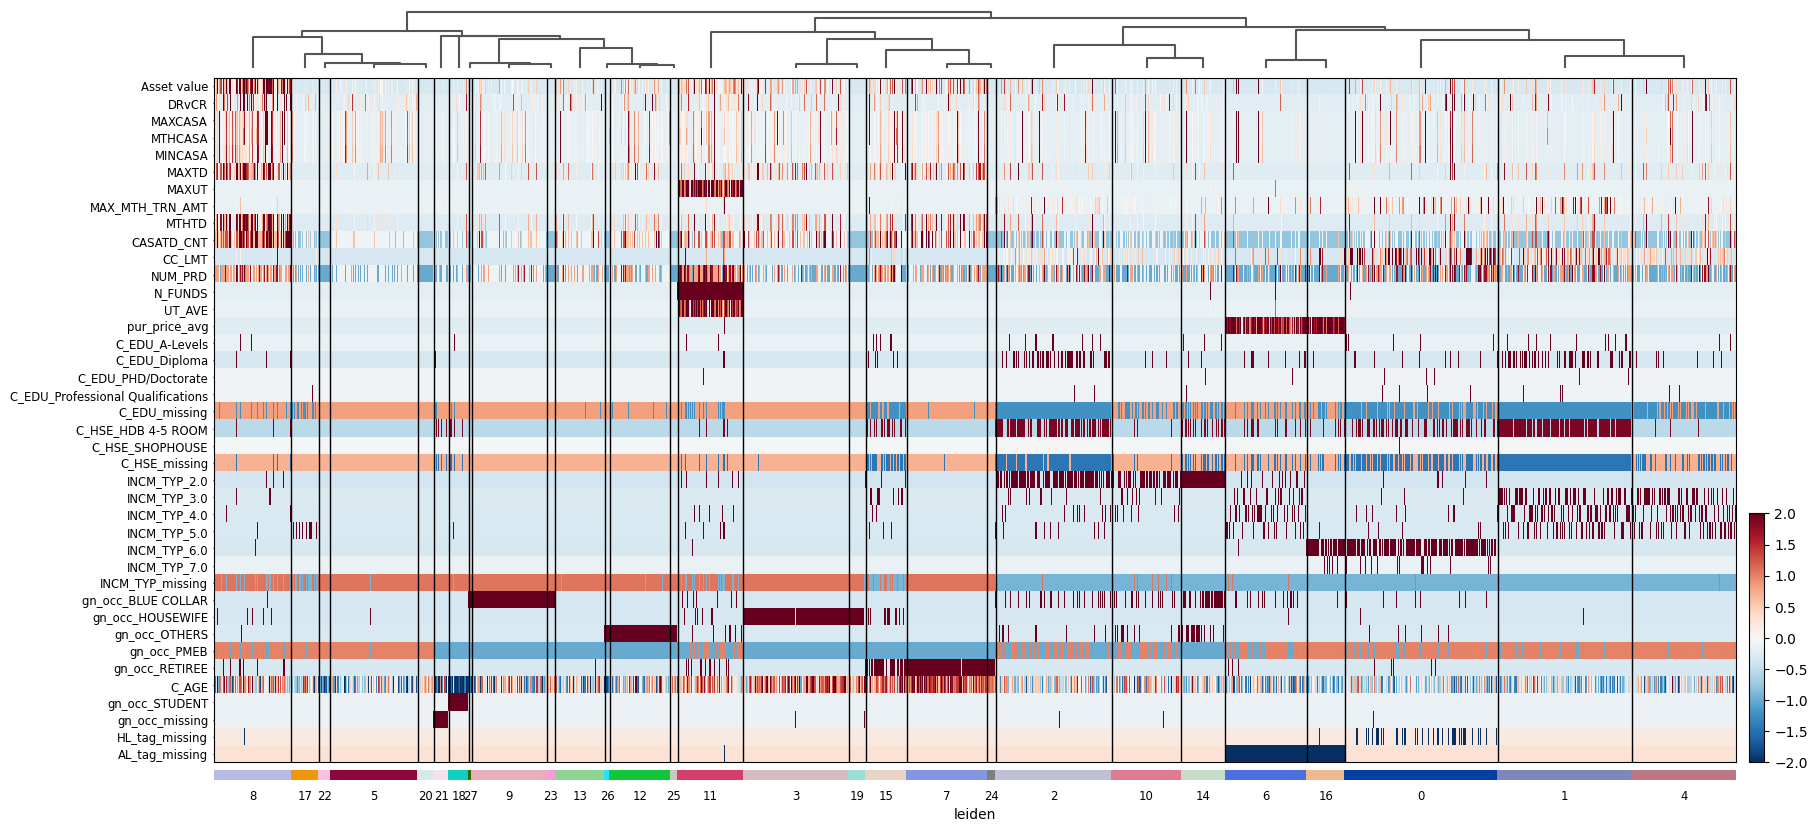

In [22]:
ax = sc.pl.heatmap(
    adata,
    var_names=features_order,
    groupby="leiden",
    # layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(20, 10),
)

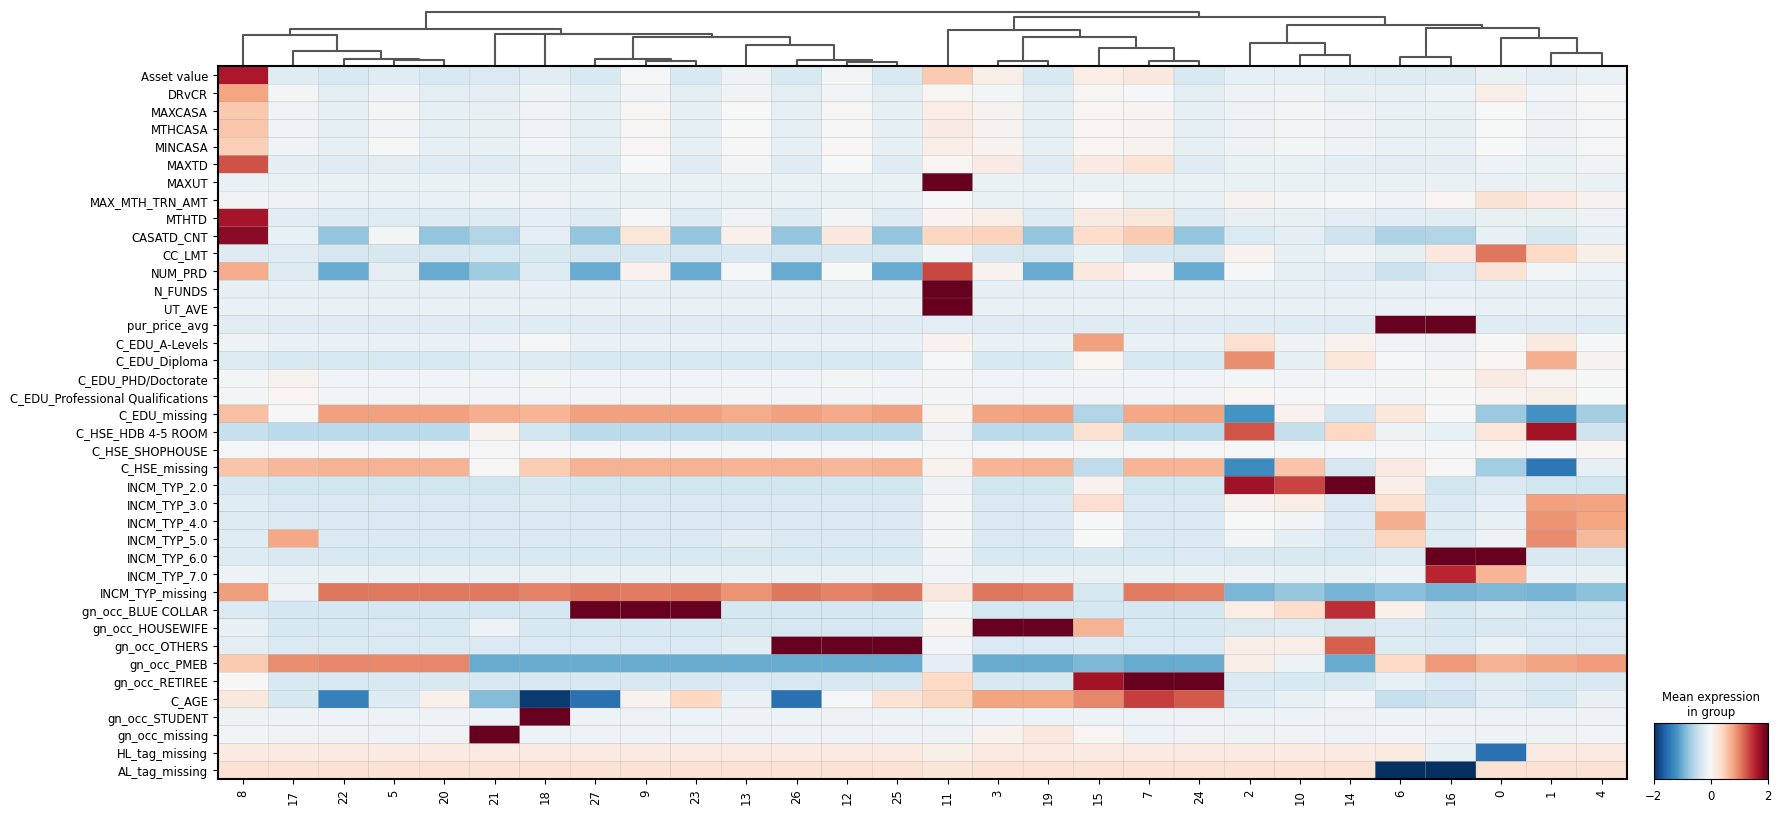

In [23]:
ax = sc.pl.matrixplot(
    adata,
    var_names=features_order,
    groupby="leiden",
    # layer="scaled",
    vmin=-2,
    vmax=2,
    cmap="RdBu_r",
    dendrogram=True,
    swap_axes=True,
    figsize=(20, 10),
)

<h3 id="kmeans" style='background:purple; border:0; color:white'><center>4. K-Means Clustering for the customers</h3>

[Back to Top](#top)

In [24]:
# obtaining the same preprocessed and transformed data from the pipeline
df_PCA = pd.DataFrame(adata.obsm['X_pca'][:, :n_PCs], columns=[f'PC{i+1}' for i in range(n_PCs)], index=adata.obs.index)
df_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
C_ID,,,,,,,
0,2.335065,-0.610707,-0.484425,-0.120428,0.042667,-0.969745,-0.657180
2,-1.221526,-2.704410,3.781884,0.059453,-1.427025,1.501960,-1.755723
8,2.043583,1.363245,0.733546,-1.172373,0.341781,0.093781,-0.605752
9,2.133940,-0.130139,-0.512049,-0.368938,1.020122,0.941341,0.777517
11,-1.920199,0.996647,0.823718,-0.608173,0.751391,-2.268007,1.235733
...,...,...,...,...,...,...,...
99977,1.189022,-1.639971,-0.399730,0.080636,0.954392,0.374334,-0.315031
99980,1.587624,-1.313925,-0.706827,0.309187,0.290333,1.315416,1.059696
99989,-2.437998,-0.310544,-0.291059,-0.169653,0.691985,-1.122453,-0.976298


In [25]:
# run kmeans clustering
from sklearn.cluster import KMeans

# kmeans doesn't estimate the number of clusters, hence we use one that determined by the graph-based clustering above
n_clusters = len(adata.obs.leiden.unique())

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=100).fit(df_PCA)
adata.obs['kmeans'] = kmeans.labels_.astype(str)



In [26]:
# calculate Silhouette Score for KMeans and leiden
from sklearn.metrics import silhouette_score
print(f'silhouette_score of kmeans: {silhouette_score(df_PCA, adata.obs.kmeans)}')
print(f'silhouette_score of leiden: {silhouette_score(df_PCA, adata.obs.leiden)}')



silhouette_score of kmeans: 0.2896063029766083
silhouette_score of leiden: 0.09773971140384674


In [27]:
# calculate Davies-Bouldin Index for KMeans and leiden
from sklearn.metrics import davies_bouldin_score
print(f'Davies-Bouldin Index of kmeans: {davies_bouldin_score(df_PCA, adata.obs.kmeans)}')
print(f'Davies-Bouldin Index of leiden: {davies_bouldin_score(df_PCA, adata.obs.leiden)}')

Davies-Bouldin Index of kmeans: 1.164553260023417
Davies-Bouldin Index of leiden: 1.2897295367738075


In [28]:
from sklearn.metrics import calinski_harabasz_score
print(f'Calinski-Harabasz Index of kmeans: {calinski_harabasz_score(df_PCA, adata.obs.kmeans)}')
print(f'Calinski-Harabasz Index of leiden: {calinski_harabasz_score(df_PCA, adata.obs.leiden)}')



Calinski-Harabasz Index of kmeans: 8541.568308210577
Calinski-Harabasz Index of leiden: 4159.179412984012


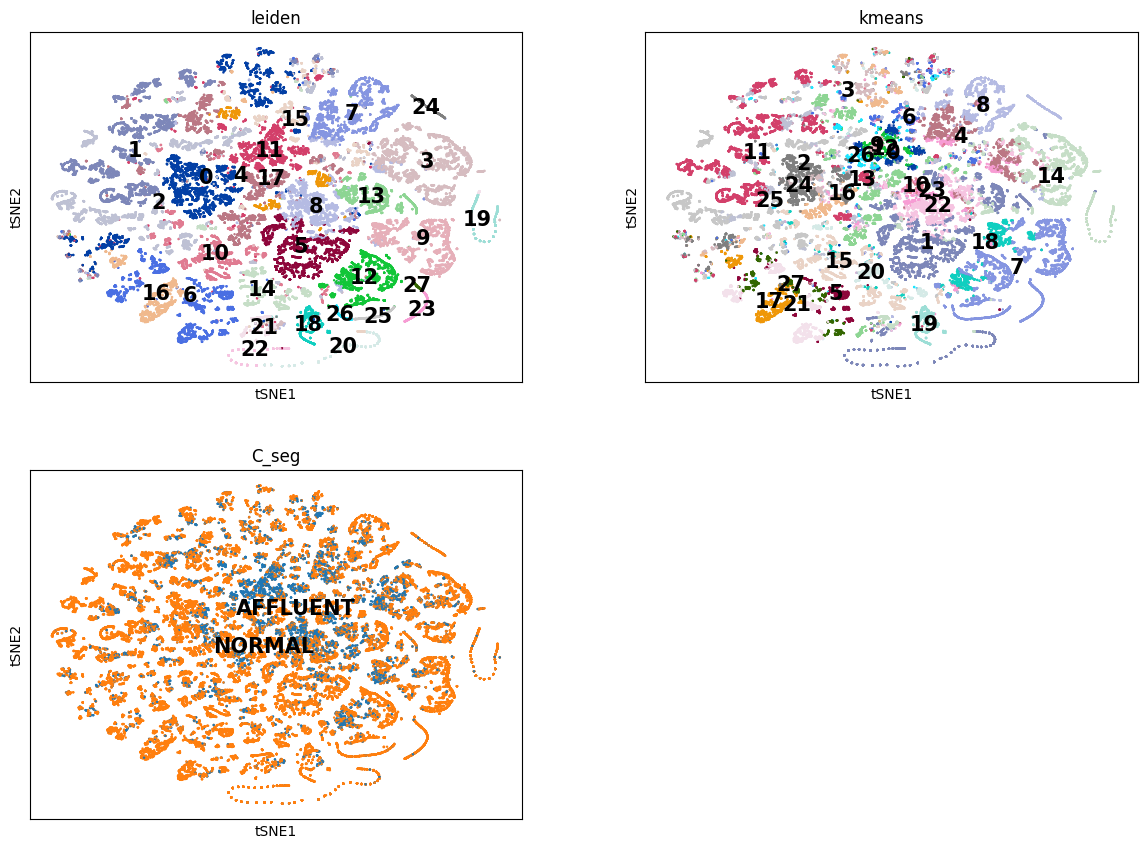

In [29]:
# we are going to compare the clustering results from the graph-based clustering and kmeans clustering using a tsne plot, 
# which is fairer 2d representation of the data compared to umap as umap is a also a graph-based method. 
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['leiden', 'kmeans', target_label], legend_loc='on data', 
           size=12, legend_fontsize=15, cmap='RdBu_r', ncols=2, 
           save=f'_{analysis_type}_{target_label}_VSkmeans.png');

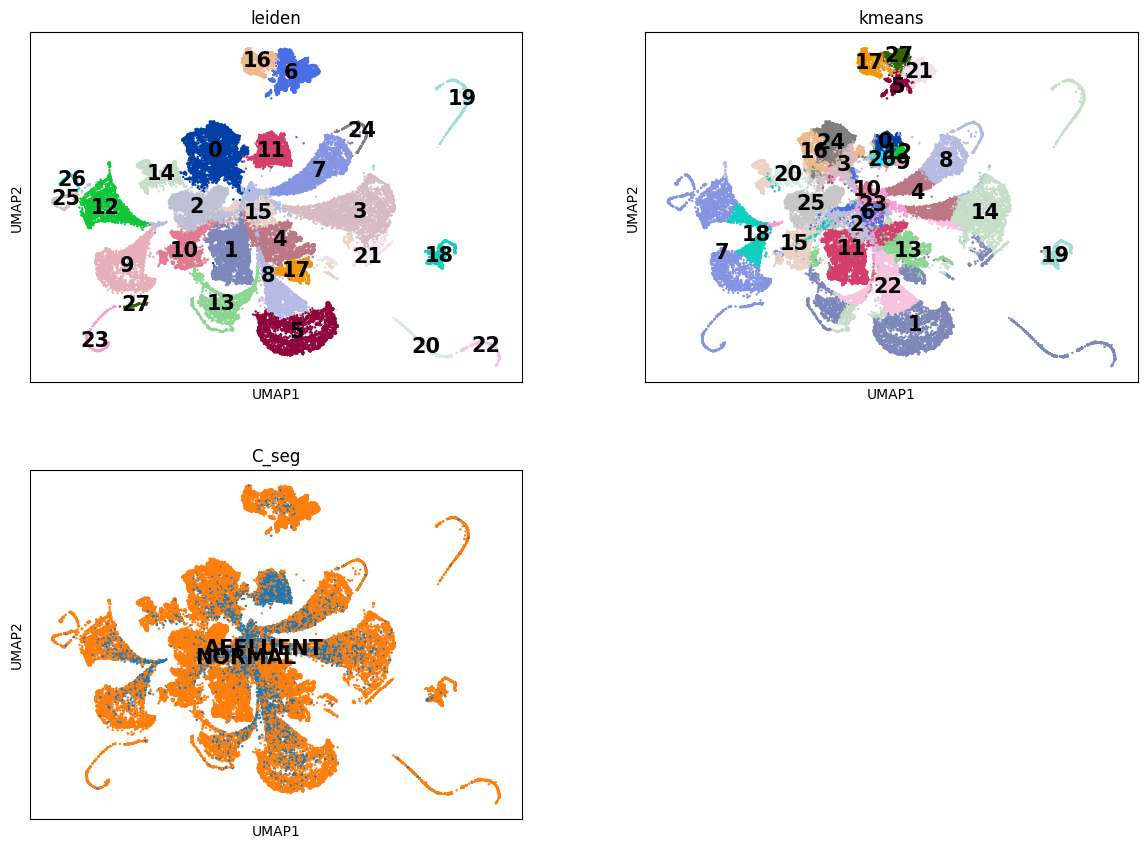

In [30]:
sc.pl.umap(adata, color=['leiden', 'kmeans', target_label], legend_loc='on data', 
           size=12, legend_fontsize=15, cmap='RdBu_r', ncols=2, 
           save=f'_{analysis_type}_{target_label}_VSkmeans.png');

In [31]:
pd.crosstab(adata.obs.leiden, adata.obs.kmeans)

kmeans,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
leiden,,,,,,,,,,,,,,,,,,,,,
0,0,3,103,928,5,0,61,8,18,0,...,15,1,34,0,17,38,2184,37,0,0
1,0,0,494,2,0,0,5,0,0,0,...,0,0,0,0,0,0,19,100,0,0
2,0,0,344,0,0,0,56,0,0,0,...,4,0,92,0,0,0,3,3101,0,0
3,0,38,0,0,721,0,0,0,54,0,...,0,0,0,0,145,18,0,0,0,0
4,0,5,316,1,0,0,22,0,0,0,...,0,0,0,0,169,24,29,16,0,0
5,0,2638,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,2,4,0,4,754,3,0,2,0,...,0,1,8,1155,3,6,0,1,2,591
7,0,0,0,0,936,0,0,0,1596,0,...,0,0,0,0,0,3,0,0,0,0
8,0,155,27,0,7,0,0,0,0,0,...,9,0,0,0,1355,645,0,0,0,0


In [32]:
df_obs_global = adata.obs

# group by leiden and C_seg and calculate the percentage of each C_seg value
df_obs_global.groupby(['leiden', 'C_seg']).size().unstack().apply(lambda x: x/x.sum(), axis=1).sort_values(by='AFFLUENT', ascending=False).style.background_gradient(cmap='bwr', axis=0)

C_seg,AFFLUENT,NORMAL
leiden,,
11,0.696117,0.303883
8,0.495847,0.504153
15,0.277649,0.722351
7,0.226162,0.773838
3,0.225068,0.774932
13,0.166026,0.833974
12,0.159222,0.840778
9,0.154530,0.845470
4,0.152095,0.847905


In [33]:
# group by leiden and C_seg and calculate the percentage of each C_seg value
df_obs_global.groupby(['kmeans', 'C_seg']).size().unstack().apply(lambda x: x/x.sum(), axis=1).sort_values(by='AFFLUENT', ascending=False).style.background_gradient(cmap='bwr', axis=0)

C_seg,AFFLUENT,NORMAL
kmeans,,
9,0.891429,0.108571
12,0.821687,0.178313
26,0.780973,0.219027
10,0.684211,0.315789
23,0.652121,0.347879
0,0.619289,0.380711
2,0.596491,0.403509
22,0.437529,0.562471
18,0.434211,0.565789
